In [2]:
import pandas as pd
import numpy as np

# Preparing Exaggerate Dataset

In [43]:
# load exaggerate dataset
exaggerate_data = pd.read_csv('exaggerate/data/working_sheet.csv', sep=";")
# drop ami, cancer
exaggerate_data = exaggerate_data.drop(columns=['ami', 'fev1', 'cbd', 'charlson', 'confusion', 'death', 'death_aecopd', 'dementia', 'home_care', 'hr','oedema', 'pad', 'retractions', 'rural', 'rr', 'saturation', 'season', 'temperature', 'dyspnoea_yesno'])
# sort columns
exaggerate_data = exaggerate_data.reindex(sorted(exaggerate_data.columns), axis=1)
print(exaggerate_data.shape)
# drop rows with more than 85% missing values
exaggerate_data = exaggerate_data.dropna(thresh=0.70*exaggerate_data.shape[1], axis=0)
# reset index to be sequential again
exaggerate_data = exaggerate_data.reset_index(drop=True)
print(exaggerate_data.shape)


# create a new variable for hypertension. If sbp variable is greater than 140 or dbp variable is greater than 90, then hypertension is 1, otherwise 0
exaggerate_data['hypertension'] = 0
exaggerate_data.loc[(exaggerate_data['sbp'] > 140) | (exaggerate_data['dbp'] > 90), 'hypertension'] = 1
# rename sex column to gender
exaggerate_data = exaggerate_data.rename(columns={'sex': 'gender', 'dyspnoea_mMRC': 'mmrc', 'aecopd_12m':'target'})
# impute age and bmi using median
exaggerate_data['age'] = exaggerate_data['age'].fillna(exaggerate_data['age'].median())
exaggerate_data['bmi'] = exaggerate_data['bmi'].fillna(exaggerate_data['bmi'].median())
# impute gender, cancer, hypertension, diabetes, heart_failure, target with most frequent value
exaggerate_data['gender'] = exaggerate_data['gender'].fillna(exaggerate_data['gender'].mode()[0])
exaggerate_data['cancer'] = exaggerate_data['cancer'].fillna(exaggerate_data['cancer'].mode()[0])
exaggerate_data['hypertension'] = exaggerate_data['hypertension'].fillna(exaggerate_data['hypertension'].mode()[0])
exaggerate_data['diabetes'] = exaggerate_data['diabetes'].fillna(exaggerate_data['diabetes'].mode()[0])
exaggerate_data['heart_failure'] = exaggerate_data['heart_failure'].fillna(exaggerate_data['heart_failure'].mode()[0])
exaggerate_data['target'] = exaggerate_data['target'].fillna(exaggerate_data['target'].mode()[0])
exaggerate_data['mmrc'] = exaggerate_data['mmrc'].fillna(exaggerate_data['mmrc'].mode()[0])
# exaggerate_data['dyspnoea_yesno'] = exaggerate_data['dyspnoea_yesno'].fillna(exaggerate_data['dyspnoea_yesno'].mode()[0])

# checking if there are any empty cells left
print("empty cells remaining in the dataset: ")
print(exaggerate_data.isna().sum().sum() / exaggerate_data.size)

# Binarize the target variable if data in target column is above 0, then set it to 1 else 0
print("target variable value counts: ")
print(exaggerate_data['target'].value_counts())
exaggerate_data.loc[exaggerate_data['target'] > 0, 'target'] = 1

# convert target to 4 classes like in harvard dataset



# exaggerate_data.loc[(exaggerate_data['target'] > 1) & (exaggerate_data['target'] <= 5), 'target'] = 2
# exaggerate_data.loc[(exaggerate_data['target'] > 5) & (exaggerate_data['target'] <= 10), 'target'] = 3
# exaggerate_data.loc[(exaggerate_data['target'] > 10), 'target'] = 4
# # add one to all target classes
# exaggerate_data['target'] = exaggerate_data['target'] + 1

print(exaggerate_data['target'].value_counts())

# drop sbp and dbp columns
exaggerate_data = exaggerate_data.drop(columns=['sbp', 'dbp'])
# save the new dataset


exaggerate_data = exaggerate_data.reindex(sorted(exaggerate_data.columns), axis=1)
exaggerate_data.to_csv('exaggerate/data/imputed_hypertension.csv', index=False, sep=';')
# correct bmi scale
exaggerate_data['bmi'] = exaggerate_data['bmi'] / 100

# min max scaling except target
X = exaggerate_data.drop(columns=['target'])
X = (X - X.min()) / (X.max() - X.min())
X['target'] = exaggerate_data['target']
exaggerate_data = X



# use smote to rebalance the exaggerate dataset in place
print("perform smote")
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(exaggerate_data.drop(columns=['target']), exaggerate_data['target'])
X_res['target'] = y_res
exaggerate_data = X_res




print(X_res['target'].value_counts())

# save the new dataset
exaggerate_data.to_csv('exaggerate/data/harvard_cv.csv', index=False, sep=';')

(1696, 10)
(1154, 10)
0    373
1    355
2    209
3    128
4     52
5     29
6      7
7      1
Name: target, dtype: int64
1    781
0    373
Name: target, dtype: int64
perform smote
0    781
1    781
Name: target, dtype: int64


# Preparing Harvard Dataset

In [44]:
# load harvard dataset
harvard_data = pd.read_csv('harvard/dropped_variables.csv', sep=";")
# drop all variables except dem02 (age), dem03 (gender), bclinra01 (height), bclinra02 (weight), bclinpt19 (cancer), bclinpt04 (hypertension), bclinpt15 (diabetes), mmrc, bclinpt07 (heart failure) , bclinpt24 (hospitalizations last 12m)  or bclinpt22 (exacerbations last 12m)
columns_to_keep = ['dem02', 'dem03', 'bclinra01', 'bclinra02', 'bclinpt19', 'bclinpt04', 'bclinpt15', 'mmrc', 'bclinpt07', 'bclinpt24']
harvard_data = harvard_data.drop(columns=set(harvard_data.columns) - set(columns_to_keep))
# rename columns to common names with exaggerate
harvard_data = harvard_data.rename(columns={'dem02':'age', 'dem03': 'gender', 'bclinpt19': 'cancer', 'bclinpt04': 'hypertension', 'bclinpt15': 'diabetes', 'bclinpt07': 'heart_failure', 'bclinpt24': 'target'})

# calculate bmi from bclinra01 and bclinra02
harvard_data['bmi'] = harvard_data['bclinra02'] / ((harvard_data['bclinra01'] / 100) ** 2)
# drop bclinra01 and bclinra02
harvard_data = harvard_data.drop(columns=['bclinra01', 'bclinra02'])
harvard_data = harvard_data.reindex(sorted(harvard_data.columns), axis=1)
harvard_data.to_csv('harvard/bmi_imputation.csv', index=False, sep=";")

# impute age, bmi with median
harvard_data['age'] = harvard_data['age'].fillna(harvard_data['age'].median())
harvard_data['bmi'] = harvard_data['bmi'].fillna(harvard_data['bmi'].median())

# impute gender, cancer, hypertension, diabetes, heart_failure, target with most frequent value
harvard_data['gender'] = harvard_data['gender'].fillna(harvard_data['gender'].mode()[0])
harvard_data['cancer'] = harvard_data['cancer'].fillna(harvard_data['cancer'].mode()[0])
harvard_data['hypertension'] = harvard_data['hypertension'].fillna(harvard_data['hypertension'].mode()[0])
harvard_data['diabetes'] = harvard_data['diabetes'].fillna(harvard_data['diabetes'].mode()[0])
harvard_data['heart_failure'] = harvard_data['heart_failure'].fillna(harvard_data['heart_failure'].mode()[0])
harvard_data['target'] = harvard_data['target'].fillna(harvard_data['target'].mode()[0])
harvard_data['mmrc'] = harvard_data['mmrc'].fillna(harvard_data['mmrc'].mode()[0])
# harvard_data['dyspnoea_yesno'] = harvard_data['dyspnoea_yesno'].fillna(harvard_data['dyspnoea_yesno'].mode()[0])

print("empty cells remaining in the dataset")
print(harvard_data.isnull().sum().sum())


# add column for dyspnoea_yesno with 0 as default as int and not nan
# harvard_data = harvard_data.assign(dyspnoea_yesno=0)
# # if mmrc is above 0 then set the 'dyspnoea_yesno' to 1 else 0
# harvard_data.loc[harvard_data['mmrc'] > 0, 'dyspnoea_yesno'] = 1
# print(harvard_data['dyspnoea_yesno'].value_counts())

# min max scaling of all variables except target
X = harvard_data.drop(columns=['target'])
X = (X - X.min()) / (X.max() - X.min())
X['target'] = harvard_data['target']
harvard_data = X


print(harvard_data['target'].value_counts())
# if target variable is 1 then set it to 0, otherwise 1
harvard_data.loc[harvard_data['target'] == 1, 'target'] = 0
# set all none 0 values to 1
harvard_data.loc[harvard_data['target'] != 0, 'target'] = 1
print(harvard_data['target'].value_counts())

# use smote to rebalance the harvard dataset in place
print("perform smote")
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(harvard_data.drop(columns=['target']), harvard_data['target'])
X_res['target'] = y_res
harvard_data = X_res

print(harvard_data['target'].value_counts())

# save dataset
harvard_data.to_csv('harvard/exaggerate_cv.csv', index=False, sep=';')

1.00    1686
2.00     632
3.00     476
4.00       2
Name: target, dtype: int64
0.00    1686
1.00    1110
Name: target, dtype: int64
perform smote
0.00    1686
1.00    1686
Name: target, dtype: int64


# Feature Space Inspection

### Distributions of both datasets

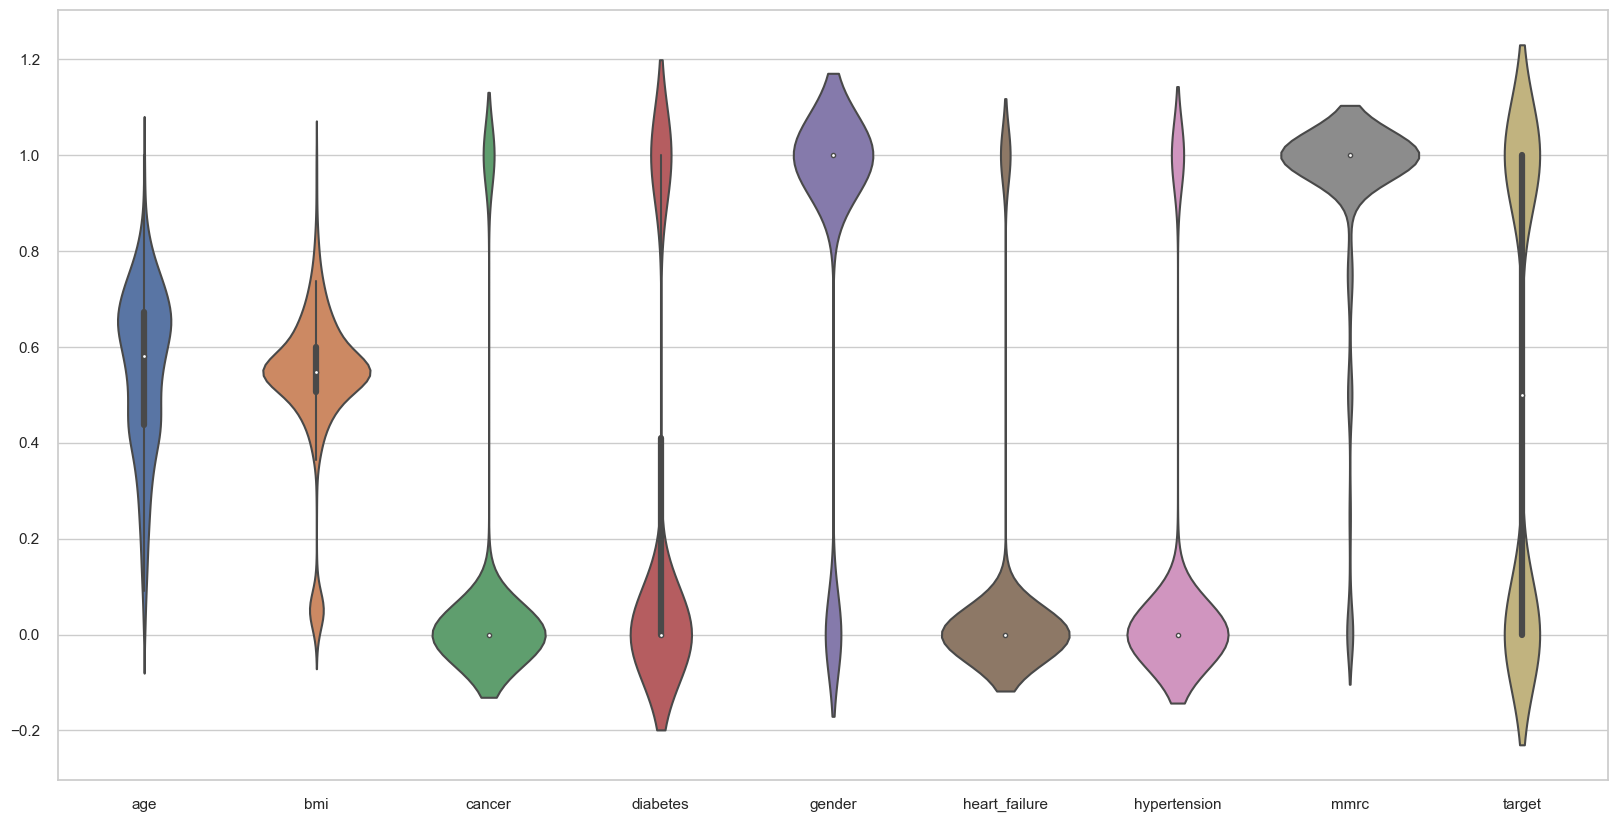

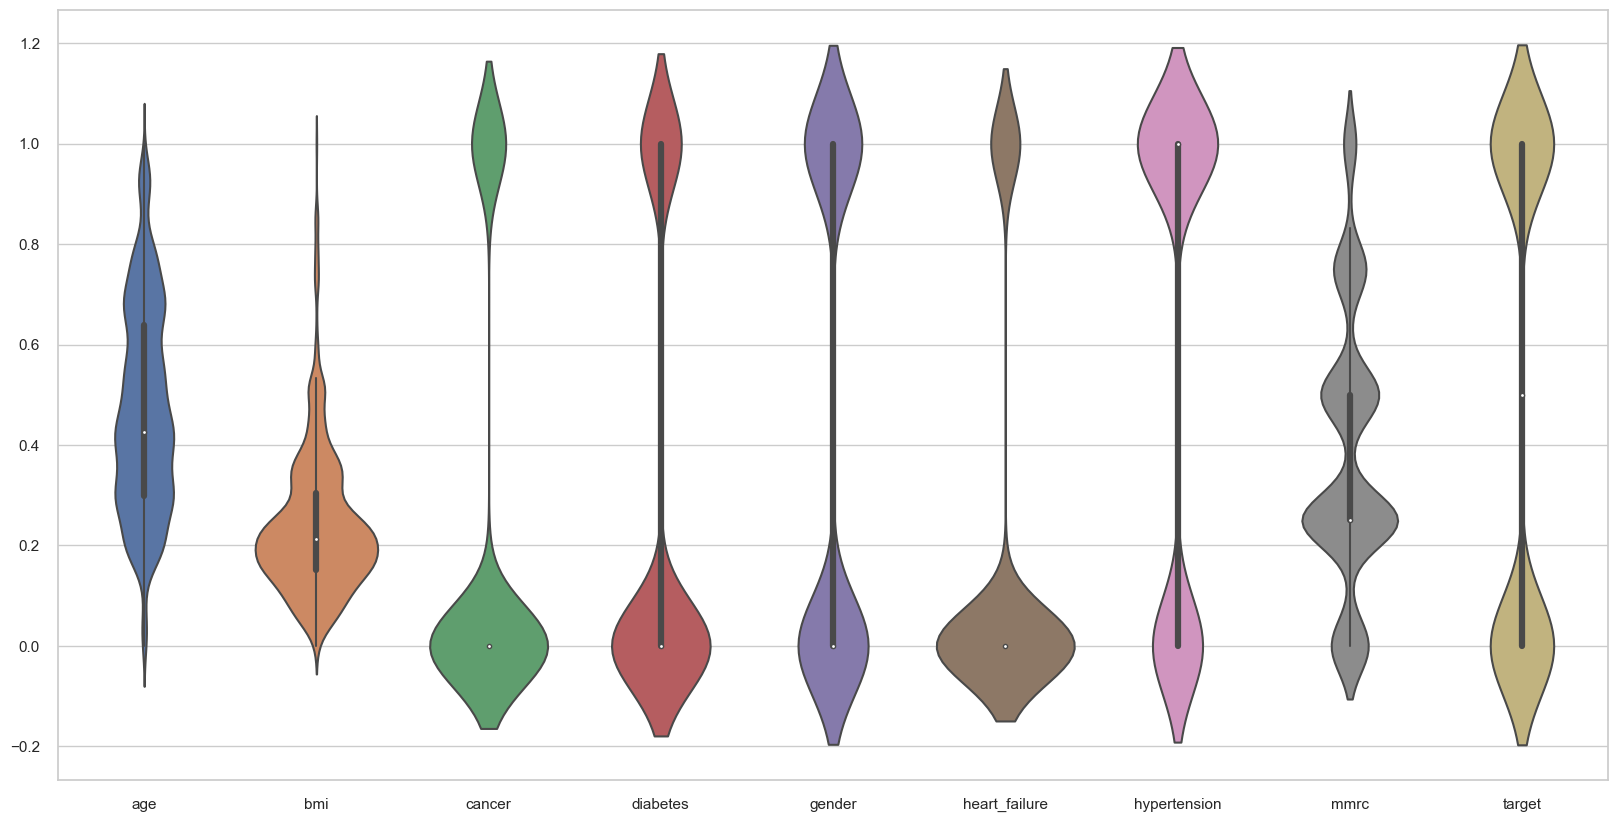

In [71]:
# plot violin plot of all variables in exaggerate
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
ax = sns.violinplot(data=exaggerate_data)
plt.show()

# plot violin plot of all variables in harvard
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
ax = sns.violinplot(data=harvard_data)
plt.show()

### Radviz Plots

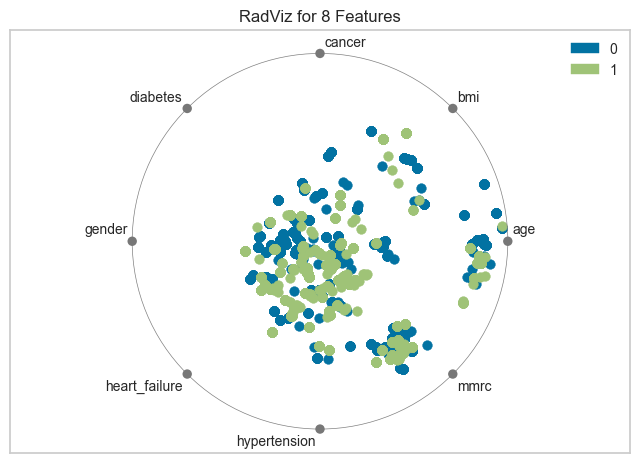

<AxesSubplot: title={'center': 'RadViz for 8 Features'}>

In [59]:
# show yellowbrick radviz for exaggerate dataset
from yellowbrick.features import RadViz

# Instantiate the visualizer
visualizer = RadViz(classes=["0", "1"])

visualizer.fit(harvard_data.drop(columns=['target']), harvard_data['target'])        # Fit the data to the visualizer
visualizer.transform(harvard_data.drop(columns=['target']))   # Transform the data
visualizer.poof()           # Finalize and render the figure



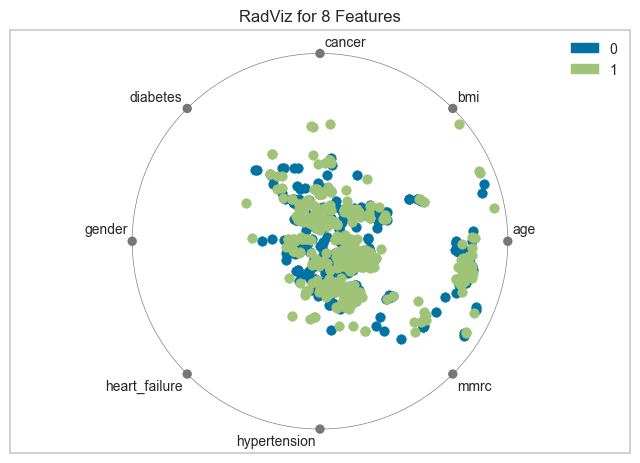

<AxesSubplot: title={'center': 'RadViz for 8 Features'}>

In [60]:
# show yellowbrick radviz for exaggerate dataset
from yellowbrick.features import RadViz

# Instantiate the visualizer
visualizer = RadViz(classes=["0", "1"])

visualizer.fit(exaggerate_data.drop(columns=['target']), exaggerate_data['target'])        # Fit the data to the visualizer
visualizer.transform(exaggerate_data.drop(columns=['target']))   # Transform the data
visualizer.poof()           # Finalize and render the figure



### PCA, Clustering and Manifold Learning

In [ ]:
# 

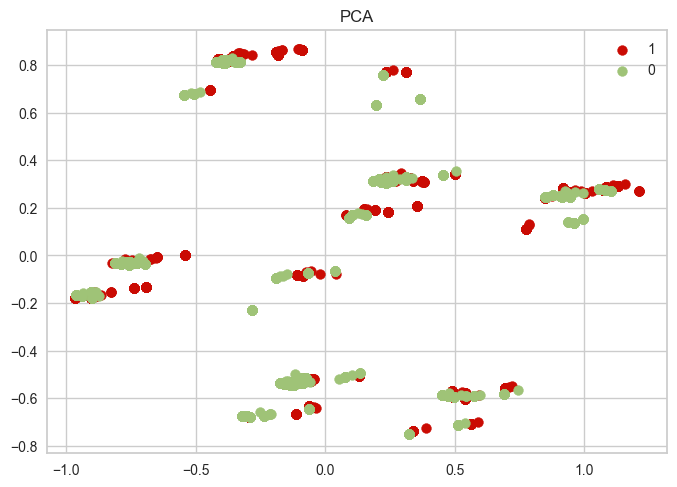

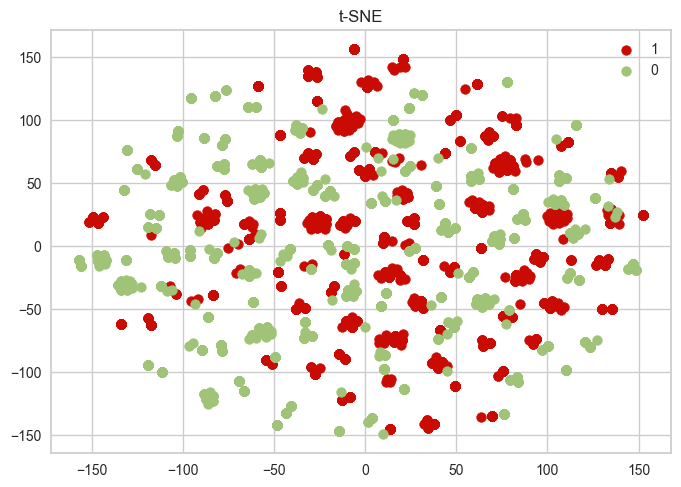

In [61]:
# PCA
features = harvard_data.drop(columns=['target'])

X = np.asarray(features)
pca = PCA(n_components=2)
features_new = pca.fit_transform(X)

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = harvard_data['target'] == target
    plt.scatter(features_new[indicesToKeep, 0], features_new[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('PCA')
plt.show()

# t-SNE
from sklearn.manifold import TSNE
from pandas import DataFrame, concat


X = np.asarray(features)
tsne = TSNE(n_components=2)
features_new = tsne.fit_transform(X)

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = harvard_data['target'] == target
    plt.scatter(features_new[indicesToKeep, 0], features_new[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('t-SNE')
plt.show()


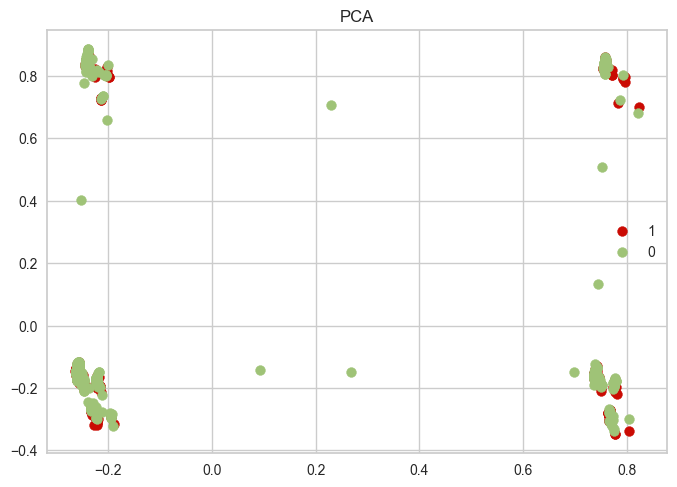

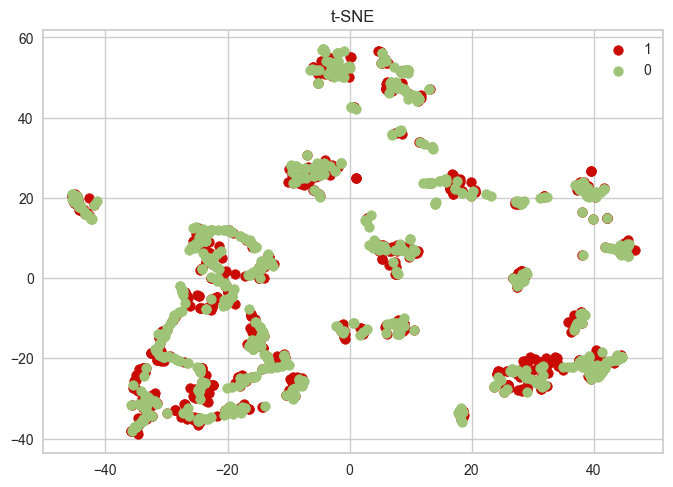

In [62]:
# PCA
from sklearn.decomposition import PCA
from pandas import DataFrame, concat
import numpy as np
import matplotlib.pyplot as plt

features = exaggerate_data.drop(columns=['target'])

X = np.asarray(features)
pca = PCA(n_components=2)
features_new = pca.fit_transform(X)

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = exaggerate_data['target'] == target
    plt.scatter(features_new[indicesToKeep, 0], features_new[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('PCA')
plt.show()

# t-SNE
from sklearn.manifold import TSNE
from pandas import DataFrame, concat


X = np.asarray(features)
tsne = TSNE(n_components=2)
features_new = tsne.fit_transform(X)

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = exaggerate_data['target'] == target
    plt.scatter(features_new[indicesToKeep, 0], features_new[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('t-SNE')
plt.show()

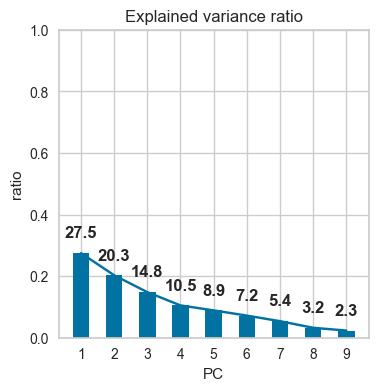

In [63]:
from matplotlib.pyplot import figure, xlabel, ylabel, scatter, show, subplots

from sklearn.decomposition import PCA
from numpy.linalg import eig
from matplotlib.pyplot import gca, title

mean = (exaggerate_data.mean(axis=0)).tolist()
centered_data = exaggerate_data - mean
cov_mtx = centered_data.cov()
eigvals, eigvecs = eig(cov_mtx)

pca = PCA()
pca.fit(centered_data)
PC = pca.components_
var = pca.explained_variance_

# PLOT EXPLAINED VARIANCE RATIO
fig = figure(figsize=(4, 4))
title('Explained variance ratio')
xlabel('PC')
ylabel('ratio')
x_values = [str(i) for i in range(1, len(pca.components_) + 1)]
bwidth = 0.5
ax = gca()
ax.set_xticklabels(x_values)
ax.set_ylim(0.0, 1.0)
ax.bar(x_values, pca.explained_variance_ratio_, width=bwidth)
ax.plot(pca.explained_variance_ratio_)
for i, v in enumerate(pca.explained_variance_ratio_):
    ax.text(i, v+0.05, f'{v*100:.1f}', ha='center', fontweight='bold')
show()



# Intra Dataset Training

In [65]:
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

X = exaggerate_data.drop(columns=['target'])
y= exaggerate_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =123)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:01<00:00, 23.57it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.74,0.74,0.74,0.74,0.19
ExtraTreesClassifier,0.71,0.71,0.71,0.71,0.16
XGBClassifier,0.70,0.70,0.70,0.70,0.07
LGBMClassifier,0.68,0.68,0.68,0.68,0.07
BaggingClassifier,0.67,0.67,0.67,0.67,0.04
KNeighborsClassifier,0.65,0.66,0.66,0.65,0.02
ExtraTreeClassifier,0.65,0.65,0.65,0.65,0.01
DecisionTreeClassifier,0.63,0.63,0.63,0.63,0.01
SVC,0.62,0.62,0.62,0.62,0.06


In [66]:
# try out algorithms on harvard
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

X = harvard_data.drop(columns=['target'])
y= harvard_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3,random_state =123)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:01<00:00, 16.23it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,1.00,1.00,1.00,1.00,0.14
LabelPropagation,1.00,1.00,1.00,1.00,0.17
RandomForestClassifier,0.99,0.99,0.99,0.99,0.16
XGBClassifier,0.99,0.99,0.99,0.99,0.08
BaggingClassifier,0.99,0.99,0.99,0.99,0.03
LGBMClassifier,0.99,0.99,0.99,0.99,0.07
KNeighborsClassifier,0.99,0.99,0.99,0.99,0.03
LabelSpreading,0.99,0.99,0.99,0.99,0.23
ExtraTreeClassifier,0.99,0.99,0.99,0.99,0.01


# Inter Dataset training

In [67]:
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier


# create trainset from exaggerate
X_train = exaggerate_data.drop(columns=['target'])
y_train = exaggerate_data['target']

# create testset from harvard
X_test = harvard_data.drop(columns=['target'])
y_test = harvard_data['target']

# train on exaggerate and test on harvard
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models


100%|██████████| 29/29 [00:02<00:00, 12.16it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.54,0.54,0.54,0.51,0.12
ExtraTreeClassifier,0.52,0.52,0.52,0.52,0.01
BaggingClassifier,0.51,0.51,0.51,0.51,0.05
LabelPropagation,0.51,0.51,0.51,0.49,0.25
LabelSpreading,0.51,0.51,0.51,0.49,0.28
KNeighborsClassifier,0.50,0.50,0.50,0.49,0.09
NuSVC,0.50,0.50,0.50,0.50,0.37
DummyClassifier,0.50,0.50,0.50,0.33,0.01
SGDClassifier,0.50,0.50,0.50,0.36,0.02


In [68]:
from sklearn.linear_model import Perceptron

# try training on harvard and testing on exaggerate

# train on PCA transformed harvard dataset
from sklearn.decomposition import PCA
X = harvard_data.drop(columns=['target'])
pca = PCA(n_components=5)
X_train = pca.fit_transform(X)


# X_train = harvard_data.drop(columns=['target'])
y_train = harvard_data['target']

# test on PCA transformed exaggerate dataset
from sklearn.decomposition import PCA
X = exaggerate_data.drop(columns=['target'])
pca = PCA(n_components=5)
X_test = pca.fit_transform(X)

# X_test = exaggerate_data.drop(columns=['target'])
y_test = exaggerate_data['target']

LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

# clf = Perceptron(tol=1e-3, random_state=0)
# clf.fit(X_train, y_train)
# print(clf.score(X_test, y_test))

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:02<00:00, 10.76it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
CalibratedClassifierCV,0.52,0.52,0.52,0.51,0.11
LogisticRegression,0.52,0.52,0.52,0.51,0.01
RidgeClassifierCV,0.52,0.52,0.52,0.51,0.01
LinearSVC,0.52,0.52,0.52,0.51,0.03
NearestCentroid,0.52,0.52,0.52,0.51,0.01
LinearDiscriminantAnalysis,0.52,0.52,0.52,0.51,0.01
RidgeClassifier,0.52,0.52,0.52,0.51,0.01
ExtraTreeClassifier,0.51,0.51,0.51,0.50,0.01
NuSVC,0.51,0.51,0.51,0.50,0.47
